# MAG Analysis

Data from the [Rothman study](https://doi.org/10.1128/AEM.01448-21) corresponding to (unenriched) samples from the [HTP site](https://en.wikipedia.org/wiki/Hyperion_sewage_treatment_plant) was downloaded from the [ENA](https://www.ebi.ac.uk/ena/browser/view/prjna729801) and processed using the [nf-core/mag](https://github.com/PhilPalmer/mag/tree/genomad) pipeline to generate assembled and binned metagenomes (as shown by the image below). Here, we will analyse the results generated by the pipeline. First, we will load and aggregate the pipeline results, explaining the steps along the way. Then, we will use the aggregated results to answer some key questions about the data such as what organisms are present in the samples and how do the taxonomic classifications generated using the reads and the assembled genomes compare.

<img src="https://raw.githubusercontent.com/nf-core/mag/master/docs/images/mag_workflow.png" width="1000">


In [166]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pysam
import seaborn as sns
import shutil
import statistics
import yaml

from Bio import SeqIO
from matplotlib import rcParams
from matplotlib.colors import LogNorm
# from matplotlib import colors as mcolors

In [2]:
########
# Change
########
# TODO: Upload directory to AWS S3 and add code to download the data if needed
data_dir = '../mag/results_rothman_htp'
group = 'group-HTP'
ribodetector_csv = f'{data_dir}/QC_shortreads/RiboDetector/summary.csv'
samples_metadata = 'https://github.com/naobservatory/kmer-egd/raw/main/rothman.unenriched.simple' 
# samples_metadata = 'https://github.com/naobservatory/illumina_pilot/raw/main/metadata/microbio_wetlab_label_match.csv'
rothman = False
assembler = 'MEGAHIT'
if samples_metadata and 'rothman' in samples_metadata.lower():
    rothman = True

##############
# Don't change
##############

# QC
fastqc_yaml = f'{data_dir}/multiqc/multiqc_data/multiqc_fastqc.yaml'

# Assembly data
bam_dir = f'{data_dir}/Assembly/{assembler}/QC/{group}'

# Genome Binning data
binner = 'MaxBin2'
busco_tsv = f'{data_dir}/GenomeBinning/QC/busco_summary.tsv'
quast_tsv = f'{data_dir}/GenomeBinning/QC/quast_summary.tsv'
bin_tsv = f'{data_dir}/GenomeBinning/bin_summary.tsv'
bin_dir = f'{data_dir}/GenomeBinning/{binner}'

# Taxonomy data
kraken_dir = f'{data_dir}/Taxonomy/kraken2'
genomad_dir = f'{data_dir}/Taxonomy/geNomad/{group}'
if assembler == 'MEGAHIT':
    genomad_class = f'{genomad_dir}/{assembler}-{group}.contigs_aggregated_classification/{assembler}-{group}.contigs_aggregated_classification.tsv'
    genomad_tax = f'{genomad_dir}/{assembler}-{group}.contigs_annotate/{assembler}-{group}.contigs_taxonomy.tsv'
if assembler == 'SPAdes':
    genomad_class = f'{genomad_dir}/{assembler}-{group}_scaffolds_aggregated_classification/{assembler}-{group}_scaffolds_aggregated_classification.tsv'
    genomad_tax = f'{genomad_dir}/{assembler}-{group}_scaffolds_annotate/{assembler}-{group}_scaffolds_taxonomy.tsv'
gtdbtk_tsv = f'{data_dir}/Taxonomy/GTDB-Tk/gtdbtk_summary.tsv'

In [3]:
# List all nested files genomad_dir
genomad_files = []
for root, dirs, files in os.walk(genomad_dir):
    for file in files:
        if file.endswith('.tsv'):
            genomad_files.append(os.path.join(root, file))

In [4]:
# Define helper functions
def decompress_gz(gz_file):
    """
    Decompress a gzipped file.
    """
    file = gz_file.replace('.gz', '')
    if os.path.exists(gz_file) and not os.path.exists(file):
        !gzip -dk {gz_file}
    return file

## Load the data

We will load the data from the key steps of the pipeline in the rough order they ran.

We will load each contig and associate it with any relevant information such as the length, bin/MAG and coverage etc. As we have information at different levels (sample, assembly, MAG and taxonomic levels) we will use IDs to link information in different dataframes.


### Quality Control (QC)
The first step of the pipeline was to perform QC on the raw reads. Here we will load the data from [FastQC](https://github.com/s-andrews/FastQC)/[MultiQC](https://github.com/ewels/MultiQC) to obtain the sample names and the total number of raw reads per sample.

In [5]:
# Read the QC data
with open(fastqc_yaml, 'r') as f:
    fastqc_data = yaml.load(f, Loader=yaml.FullLoader)

# Get the sample IDs and the total number of raw reads
sample_read_counts = {k: fastqc_data[k]['Total Sequences'] for k in fastqc_data.keys()}
sample_read_counts = {k.replace('_1',''): int(sample_read_counts[k] + sample_read_counts[k.replace('_1', '_2')]) for k in sample_read_counts.keys() if '_1' in k}
samples = list(sample_read_counts.keys())
print(samples)

['SRR14530762', 'SRR14530763', 'SRR14530764', 'SRR14530765', 'SRR14530766', 'SRR14530767', 'SRR14530769', 'SRR14530770', 'SRR14530771', 'SRR14530772', 'SRR14530880', 'SRR14530881', 'SRR14530882', 'SRR14530884', 'SRR14530885', 'SRR14530886', 'SRR14530887', 'SRR14530888', 'SRR14530889', 'SRR14530890', 'SRR14530891']


In [350]:
import plotly.graph_objects as go

retained_nts = {}
nt_counts = f'{data_dir}/QC_shortreads/adapterremoval/nt_counts.csv'
nt_counts_df = pd.read_csv(nt_counts, index_col=0)

for sample in samples:

    trim_log = f'{data_dir}/QC_shortreads/adapterremoval/{sample}/{sample}_ar2.log'

    # Extract 'Number of retained nucleotides: X' from the log file
    with open(trim_log, 'r') as f:
        for line in f:
            if 'Number of retained nucleotides' in line:
                retained_nts[sample] = int(line.split(': ')[1].strip())

retained_nts_df = pd.DataFrame.from_dict(retained_nts, orient='index', columns=['retained_nts'])
# retained_nts_df['raw_nts'] = retained_nts_df['retained_nts'] * 1.01
# retained_nts_df['raw_nts'] = retained_nts_df['raw_nts'].astype(int)
# Merge with nt_counts_df
retained_nts_df = retained_nts_df.merge(nt_counts_df, left_index=True, right_index=True)
retained_nts_df['raw_nts'] = retained_nts_df['read_1_count'] + retained_nts_df['read_2_count']
# retained_nts_df.loc['Total'] = retained_nts_df.sum()
retained_nts_df['retained_nts_pct'] = retained_nts_df['retained_nts'] / retained_nts_df['raw_nts'] * 100
retained_nts_df


retained_nts  read_1_count  read_2_count     raw_nts  \
SRR14530762    1081054328     544114400     544114400  1088228800   
SRR14530763    1072386614     539752304     539752304  1079504608   
SRR14530764    1088600880     547911208     547911208  1095822416   
SRR14530765    1052843790     529911216     529911216  1059822432   
SRR14530766     845609182     425605928     425605928   851211856   
SRR14530767    1002127664     504388896     504388896  1008777792   
SRR14530769    1273052968     640751592     640751592  1281503184   
SRR14530770    1313904680     661313088     661313088  1322626176   
SRR14530771     658107960     331233840     331233840   662467680   
SRR14530772    1387730792     698471768     698471768  1396943536   
SRR14530880    2752531348    1389922176    1389922176  2779844352   
SRR14530881    2606586788    1316223300    1316223300  2632446600   
SRR14530882    2323778560    1173414732    1173414732  2346829464   
SRR14530884    1789989240     903875652     903875652  1807751304   
SRR14530885    2415921412    1219943766    1219943766  2439887532   
SRR14530886    2196623186    1109209608    1109209608  2218419216   
SRR14530887    2406343074    1215108558    1215108558  2430217116   
SRR14530888    2329927248    1176521346    1176521346  2353042692   
SRR14530889    2231221678    1126679454    1126679454  2253358908   
SRR14530890    3311653496    1672255014    1672255014  3344510028   
SRR14530891    1944506564     981898614     981898614  1963797228   

             retained_nts_pct  
SRR14530762         99.340720  
SRR14530763         99.340624  
SRR14530764         99.340994  
SRR14530765         99.341527  
SRR14530766         99.341800  
SRR14530767         99.340774  
SRR14530769         99.340601  
SRR14530770         99.340593  
SRR14530771         99.341897  
SRR14530772         99.340507  
SRR14530880         99.017463  
SRR14530881         99.017651  
SRR14530882         99.017785  
SRR14530884         99.017450  
SRR14530885         99.017737  
SRR14530886         99.017497  
SRR14530887         99.017617  
SRR14530888         99.017636  
SRR14530889         99.017590  
SRR14530890         99.017598  
SRR14530891         99.017686

In [349]:
node_label = ['Total Raw Nucleotides', *['Raw ' + s for s in retained_nts_df.index], *['Retained ' + s for s in retained_nts_df.index], 'Total Retained Nucleotides']
node_dict = {y:x for x, y in enumerate(node_label)}

source = [node_dict['Total Raw Nucleotides']] * len(samples) + [node_dict['Raw ' + s] for s in retained_nts_df.index] + [node_dict['Retained ' + s] for s in retained_nts_df.index]
target = [node_dict['Raw ' + s] for s in retained_nts_df.index] + [node_dict['Retained ' + s] for s in retained_nts_df.index] + [node_dict['Total Retained Nucleotides']] * len(samples) 
values = retained_nts_df['raw_nts'].tolist() + retained_nts_df['retained_nts'].tolist() + retained_nts_df['retained_nts'].tolist()

# Create a color map for each sample
sample_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]

fig = go.Figure(go.Sankey(
    valueformat = ".0f",
    valuesuffix = " bp",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_label,
      color = ["blue"] + sample_colors * 2
    ),
    # Add links
    link = dict(
      source = source,
      target = target,
      value = values
    )
))

fig.show()

In [348]:
# # Create a color map for each sample
# sample_colors = {s: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for s in retained_nts_df.index}

# node_label = ['Total Raw Nucleotides', *['Raw ' + s for s in retained_nts_df.index], *['Retained ' + s for s in retained_nts_df.index], 'Total Retained Nucleotides']
# node_dict = {y:x for x, y in enumerate(node_label)}

# source = [node_dict['Total Raw Nucleotides']] * len(samples) + [node_dict['Raw ' + s] for s in retained_nts_df.index] + [node_dict['Retained ' + s] for s in retained_nts_df.index]
# target = [node_dict['Raw ' + s] for s in retained_nts_df.index] + [node_dict['Retained ' + s] for s in retained_nts_df.index] + [node_dict['Total Retained Nucleotides']] * len(samples) 
# values = retained_nts_df['raw_nts'].tolist() + retained_nts_df['retained_nts'].tolist() + retained_nts_df['retained_nts'].tolist()

# # Define nodes colors
# node_colors = ["blue"] + [sample_colors[s] for s in retained_nts_df.index] * 2

# fig = go.Figure(go.Sankey(
#     valueformat = ".0f",
#     valuesuffix = " bp",
#     # Define nodes
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = node_label,
#       color = node_colors
#     ),
#     # Add links
#     link = dict(
#     source = source,
#     target = target,
#     value = values,
#     color = [sample_colors[s] for s in retained_nts_df.index]*3,
#     )
# ))

# fig.show()


In [6]:
if samples_metadata and not rothman:
    samples_df = pd.read_csv(samples_metadata, index_col=0)
    samples_df.index = samples_df.index.str.split('-').str[-1]
    display(samples_df)

In [7]:
if os.path.exists(ribodetector_csv):
    ribo_df = pd.read_csv(ribodetector_csv, index_col=0)
    ribo_df['n_rrna_reads'] = ribo_df['n_total_reads'] - ribo_df['n_nonrrna_reads']
    ribo_df.loc['total'] = ribo_df.sum()
    ribo_df['perc_rrna_reads'] = ribo_df['n_rrna_reads'] / ribo_df['n_total_reads'] * 100
    display(ribo_df.style.format({'n_total_reads': '{:,.0f}'.format,'n_rrna_reads': '{:,.0f}'.format,'n_nonrrna_reads': '{:,.0f}'.format,'perc_rrna_reads': '{:.2f}%'.format})\
        .bar(subset=ribo_df.columns[:3], color='#d65f5f')\
        .bar(subset=['perc_rrna_reads'], color='#5fba7d', vmax=100))

### Assemblies

[metaSPAdes](http://cab.spbu.ru/software/spades/) was used for the assembly i.e. merging of reads.

(We will skip loading the contigs here because instead, we will load the MAGs (in the next step) which includes the same information for the contigs and additional information such as the bin).

#### Getting read counts for the contigs and samples

Here we will generate a count matrix i.e. a file mapping contig IDs (rows) and sample IDs (columns).

The nf-core/mag pipeline already maps the reads back to the contigs using [bowtie2](https://github.com/BenLangmead/bowtie2) (see [code](https://github.com/nf-core/mag/blob/master/modules/local/bowtie2_assembly_align.nf#L23-L30)). Therefore, we can use [samtools](http://www.htslib.org/) to get the read counts for each contig and sample (see [example](https://github.com/edamame-course/Metagenome/blob/master/2018-06-29-counting-abundance-with-mapped-reads.md#option-1-count-each-contigs)). The third column in the tab-seperated output from [`samtools idxstats`](http://www.htslib.org/doc/samtools-idxstats.html) is the number of reads mapped to the contig which we'll use to generate the count matrix.

##### How does bowtie2 align reads to contigs?
Bowtie2 suppports different modes of alignment. The default mode (used by the nf-core/mag pipeline) is "end-to-end" alignment which uses all characters in the read for alignment, e.g.:
```
Alignment:
  Read:      GACTGGGCGATCTCGACTTCG
             |||||  |||||||||| |||
  Reference: GACTG--CGATCTCGACATCG
```

An alignment score is used to quantify how similiar the read is to the aligned contig sequence. The higher the score, the more similiar the read is to the contig. A mismatched base at a high-quality position in the read receives a penalty of -6 by default. A length-2 read gap receives a penalty of -11 by default (-5 for the gap open, -3 for the first extension, -3 for the second extension). Thus, in end-to-end alignment mode, if the read is 150 bp long and it matches the reference exactly except for one mismatch at a high-quality position and one length-2 read gap, then the overall score is -(6 + 11) = -17. The best possible alignment score in end-to-end mode is 0, which happens when there are no differences between the read and the reference

A "match" is determined if the alignment score is no less than the minimum score threshold. In end-to-end alignment mode, the default minimum score threshold is `-0.6 + -0.6 * L`, where `L` is the read length. For example, using a read length of 150 bp, the minimum score threshold is `-0.6 + -0.6 * 150 = -90.6`. Therefore, if the alignment score is no less than -90 (e.g. there are fewer than 15 high-quality mismatches and no gaps), then the read is considered a "match".

<!--
Bowtie2 uses a heuristic to determine whether a read is "good enough" to be considered a "match". The heuristic is based on the read length and the alignment score. The alignment score is the sum of the scores of the matching bases and gaps. The alignment score is compared to a minimum score threshold. If the alignment score is no less than the minimum score threshold, then the read is considered "good enough" to be considered aligned. The minimum score threshold is configurable and is expressed as a function of the read length. In end-to-end alignment mode, the default minimum score threshold is `-0.6 + -0.6 * L`, where `L` is the read length. For example, using a read length of 150 bp, the minimum score threshold is `-0.6 + -0.6 * 150 = -90.6`. Therefore, if the alignment score is no less than -90 (e.g. there are fewer than 15 high-quality mismatches), then the read is considered a "match" and the contig is considered to have a read mapped to it. Information from both of the paired reads is also used in the alignment.
-->

In [8]:
# Get absolute path for bam_dir and generate a list of all of the bams
bam_dir = os.path.abspath(bam_dir)
bams = [f'{bam_dir}/{bam}' for bam in os.listdir(bam_dir) if bam.endswith('.bam')]

# Check if samtools is installed locally, if not, use the docker container from the nf-core/mag pipeline to run samtools
if shutil.which('samtools'):
    samtools_cmd = 'samtools'
else:
    samtools_cmd = f'docker run -v {bam_dir}:{bam_dir} -w {bam_dir} quay.io/biocontainers/mulled-v2-ac74a7f02cebcfcc07d8e8d1d750af9c83b4d45a:577a697be67b5ae9b16f637fd723b8263a3898b3-0 samtools'

# Run samtools idxstats on all of the bams
for bam in bams:
    sample = bam.split('/')[-1].split('.')[0].split('-')[-1]
    if not os.path.exists(f'{bam_dir}/{sample}_idxstats.txt'):
        # TODO: Use a method that assigns each read to the single best matching contig only and doesn't count reads multiple times
        !{samtools_cmd} idxstats {bam} > {bam_dir}/{sample}_idxstats.txt

In [9]:
# Load and concatenate the idxstats files
idxstat_cols = ['contig', 'length', 'num_mapped_reads', 'num_unmapped_reads']
idxstat_dfs = []

# Get a list of all of the idxstats files
idxstats = [f'{bam_dir}/{idxstat}' for idxstat in os.listdir(bam_dir) if idxstat.endswith('_idxstats.txt')]

# Read in the idxstats files
for idxstat in idxstats:
    sample = idxstat.split('/')[-1].split('_')[0]
    idxstat_df = pd.read_csv(idxstat, sep='\t', header=None, names=idxstat_cols)
    idxstat_df['sample_id'] = sample
    idxstat_dfs.append(idxstat_df)

# Combine the idxstats dataframes into a single dataframe
counts_df = pd.concat(idxstat_dfs, axis=0)
counts_df.contig = counts_df.contig.str.split('_').str[1]

In [10]:
# Reformat the dataframe so that the contigs are the index and the samples are the columns
counts_df = counts_df.pivot(index='contig', columns='sample_id', values='num_mapped_reads')

# Sort the dataframe
counts_df = counts_df[~counts_df.index.isnull()]
counts_df.index = counts_df.index.astype(int)
counts_df = counts_df.sort_index()

counts_df

sample_id  SRR14530762  SRR14530763  SRR14530764  SRR14530765  SRR14530766  \
contig                                                                       
0                    0            0            0            0            0   
1                    0            1            0            0            0   
2                    1            0            0            0            0   
3                    0            2            0            1            1   
4                    0            4            0            0            0   
...                ...          ...          ...          ...          ...   
171578               1            0            0            0            0   
171579               0            0            0            0            0   
171580               0            0            0            0            0   
171581               0            0            0            0            0   
171582               1            0            0            0            0   

sample_id  SRR14530767  SRR14530769  SRR14530770  SRR14530771  SRR14530772  \
contig                                                                       
0                    0            0            0            0            0   
1                    0            0            0            0            1   
2                    0            0            0            0            0   
3                    0            0            0            0            0   
4                    0            0            0            0            0   
...                ...          ...          ...          ...          ...   
171578               0            1            0            0            0   
171579               0            0            0            0            0   
171580               0            0            0            0            0   
171581               2            0            0            0            0   
171582               0            0            0            1            0   

sample_id  ...  SRR14530881  SRR14530882  SRR14530884  SRR14530885  \
contig     ...                                                       
0          ...            1            2            0            0   
1          ...            0            0            0            0   
2          ...            7           26            2            1   
3          ...            0            0            0            0   
4          ...            0            0            0            0   
...        ...          ...          ...          ...          ...   
171578     ...            0            0            0            0   
171579     ...            0            0            0            0   
171580     ...            0            0            0            0   
171581     ...            0            0            0            0   
171582     ...            0            0            2            1   

sample_id  SRR14530886  SRR14530887  SRR14530888  SRR14530889  SRR14530890  \
contig                                                                       
0                    6            0            0            0            0   
1                    0            0            0            0            0   
2                    1           11            7            0            3   
3                    0            0            0            0            0   
4                    0            0            0            0            0   
...                ...          ...          ...          ...          ...   
171578               0            0            0            0            0   
171579               0            0            0            0            2   
171580               0            0            0            0            0   
171581               0            0            0            0            0   
171582               5            0            0            0           17   

sample_id  SRR14530891  
contig             

### Genome binning

Here we will load the bins/MAGs

- Two tools were used to perform metagenome binning to generate metagenome assembled genomes (MAGs) - [MetaBAT2](https://bitbucket.org/berkeleylab/metabat/src/master/) and [MaxBin2](https://sourceforge.net/projects/maxbin2/)

- And two tools were used to check for quality control (QC) of the genome bins - [Busco](https://busco.ezlab.org/) and [Quast](http://quast.sourceforge.net/quast)


Let's look the summary information of the bins/MAGs


In [11]:
pd.set_option('display.max_columns', None)

bin_summary_df = pd.read_csv(bin_tsv, sep='\t', index_col=0)
bin_summary_df.head()

bin  Depth SRR14530762  Depth SRR14530763  \
0  MEGAHIT-MetaBAT2-group-HTP.3.fa           0.054866           0.107397   
1  MEGAHIT-MetaBAT2-group-HTP.2.fa           0.054258           6.548310   
2  MEGAHIT-MetaBAT2-group-HTP.1.fa           0.000000           0.283851   
3  MEGAHIT-MetaBAT2-group-HTP.7.fa           0.000000           0.000000   
4  MEGAHIT-MetaBAT2-group-HTP.4.fa           0.106773           0.215191   

   Depth SRR14530764  Depth SRR14530765  Depth SRR14530766  Depth SRR14530767  \
0           0.106844           0.077458           0.054793           0.108633   
1           0.152741           0.059707           0.000000           0.000000   
2           1.330145           0.644232           0.293378           0.404463   
3           0.000000           0.000000           0.000000           0.000000   
4           0.187597           0.112032           0.110314           0.211635   

   Depth SRR14530769  Depth SRR14530770  Depth SRR14530771  Depth SRR14530772  \
0           0.131274           0.000000           0.000000           0.000000   
1           0.000000           0.000000           0.000000           0.093244   
2           0.000000           0.387476           0.527226           1.082450   
3           0.000000           0.000000           0.000000           0.000000   
4           0.200156           0.000000           0.000000           0.059774   

   Depth SRR14530880  Depth SRR14530881  Depth SRR14530882  Depth SRR14530884  \
0           0.912205           0.979503           1.151375           0.544742   
1           0.000000           0.000000           0.000000           0.000000   
2           0.000000           0.000000           0.000000           0.000000   
3           0.000000           0.000000           0.441423           0.185520   
4           1.600140           1.753270           1.919305           0.847606   

   Depth SRR14530885  Depth SRR14530886  Depth SRR14530887  Depth SRR14530888  \
0           0.706978           0.629112           1.400100           0.950719   
1           0.000000           0.000000           0.000000           0.041185   
2           0.000000           0.000000           0.000000           0.000000   
3           0.000000           3.979045           0.324222           0.054862   
4           1.264800           1.163890           2.510825           1.652125   

   Depth SRR14530889  Depth SRR14530890  Depth SRR14530891  \
0           0.827672           0.910066           1.159475   
1           0.000000           0.000000           0.000000   
2           0.000000           0.000000           0.000000   
3           0.382997           0.696643           0.000000   
4           1.440165           1.599945           2.277115   

                         GenomeBin           Domain  %Complete (domain)  \
0  MEGAHIT-MetaBAT2-group-HTP.3.fa   bacteria_odb10                 2.4   
1  MEGAHIT-MetaBAT2-group-HTP.2.fa          Viruses                 NaN   
2  MEGAHIT-MetaBAT2-group-HTP.1.fa   bacteria_odb10                17.7   
3  MEGAHIT-MetaBAT2-group-HTP.7.fa   bacteria_odb10                16.9   
4  MEGAHIT-MetaBAT2-group-HTP.4.fa  eukaryota_odb10                 2.0   

   %Complete and single-copy (domain)  %Complete and duplicated (domain)  \
0                                 2.4                                0.0   
1                                 NaN                                NaN   
2                                17.7                                0.0   
3                                16.9                                0.0   
4                                 2.0                                0.0   

   %Fragmented (domain)  %Missing (domain)  Total number (domain)  \
0                   0.0               97.6                  124.0   
1                   NaN                NaN                    NaN   
2                   6.5               75.8                  124.0   
3                  10.5               72.6                  124.0   


The results from the tools show that MaxBin2 generated more genome bins and a higher % completeness than MetaBAT2


In [12]:
busco_df = pd.read_csv(busco_tsv, sep='\t')
busco_df.head()

GenomeBin           Domain  %Complete (domain)  \
0  MEGAHIT-MaxBin2-group-HTP.003.fa   bacteria_odb10                39.5   
1  MEGAHIT-MaxBin2-group-HTP.001.fa  eukaryota_odb10                 0.8   
2   MEGAHIT-MetaBAT2-group-HTP.1.fa   bacteria_odb10                17.7   
3   MEGAHIT-MetaBAT2-group-HTP.7.fa   bacteria_odb10                16.9   
4  MEGAHIT-MaxBin2-group-HTP.006.fa   bacteria_odb10                31.4   

   %Complete and single-copy (domain)  %Complete and duplicated (domain)  \
0                                27.4                               12.1   
1                                 0.8                                0.0   
2                                17.7                                0.0   
3                                16.9                                0.0   
4                                29.8                                1.6   

   %Fragmented (domain)  %Missing (domain)  Total number (domain)  \
0                  17.7               42.8                  124.0   
1                   0.0               99.2                  255.0   
2                   6.5               75.8                  124.0   
3                  10.5               72.6                  124.0   
4                  23.4               45.2                  124.0   

  Specific lineage dataset  %Complete (specific)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3        rhizobiales_odb10                  10.2   
4                      NaN                   NaN   

   %Complete and single-copy (specific)  %Complete and duplicated (specific)  \
0                                   NaN                                  NaN   
1                                   NaN                                  NaN   
2                                   NaN                                  NaN   
3                                  10.2                                  0.0   
4                                   NaN                                  NaN   

   %Fragmented (specific)  %Missing (specific)  Total number (specific)  
0                     NaN                  NaN                      NaN  
1                     NaN                  NaN                      NaN  
2                     NaN                  NaN                      NaN  
3                     3.1                 86.7                    639.0  
4                     NaN                  NaN                      NaN

In [13]:
quast_df = pd.read_csv(quast_tsv, sep='\t')
quast_df.head()

Assembly  # contigs (>= 0 bp)  \
0  MEGAHIT-MaxBin2-group-HTP.001.fa                  236   
1  MEGAHIT-MaxBin2-group-HTP.002.fa                  389   
2  MEGAHIT-MaxBin2-group-HTP.005.fa                 2467   
3  MEGAHIT-MaxBin2-group-HTP.006.fa                 2524   
4  MEGAHIT-MaxBin2-group-HTP.004.fa                 1790   

   # contigs (>= 1000 bp)  # contigs (>= 5000 bp)  # contigs (>= 10000 bp)  \
0                     236                      30                        0   
1                     389                      82                       54   
2                    2467                      96                        9   
3                    2524                      20                        3   
4                    1790                      22                        4   

   # contigs (>= 25000 bp)  # contigs (>= 50000 bp)  Total length (>= 0 bp)  \
0                        0                        0                  635408   
1                       37                       19                 4195991   
2                        0                        0                 5106868   
3                        0                        0                 3608169   
4                        0                        0                 2867839   

   Total length (>= 1000 bp)  Total length (>= 5000 bp)  \
0                     635408                     209126   
1                    4195991                    3581334   
2                    5106868                     665011   
3                    3608169                     155362   
4                    2867839                     181539   

   Total length (>= 10000 bp)  Total length (>= 25000 bp)  \
0                           0                           0   
1                     3399710                     3121146   
2                      123847                           0   
3                       43289                           0   
4                       66135                           0   

   Total length (>= 50000 bp)  # contigs  Largest contig  Total length  \
0                           0        236            9855        635408   
1                     2435059        389          391780       4195991   
2                           0       2467           15940       5106868   
3                           0       2524           21457       3608169   
4                           0       1790           21773       2867839   

   GC (%)    N50    N75  L50   L75  # N's per 100 kbp # predicted rRNA genes  
0   42.30   3563   1949   56   119                0.0             0 + 0 part  
1   56.84  75645  24468   14    39                0.0             0 + 0 part  
2   62.51   2259   1470  698  1403                0.0             1 + 0 part  
3   48.76   1329   1129  932  1673                0.0             0 + 0 part  
4   65.01   1526   1221  609  1138                0.0             0 + 0 part

We will therefore use the MaxBin2 results for the rest of the analysis


In [14]:
# Get the bin files
bin_files = []

for dirpath, dirnames, filenames in os.walk(bin_dir):
    bin_files.extend([os.path.join(dirpath, file) for file in filenames if file.endswith('.gz')])

bin_files

['../mag/results_rothman_htp/GenomeBinning/MaxBin2/unbinned/discarded/MEGAHIT-MaxBin2-group-HTP.noclass.pooled.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/unbinned/discarded/MEGAHIT-MaxBin2-group-HTP.noclass.remaining.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.003.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.002.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.004.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.001.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.006.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/MEGAHIT-MaxBin2-group-HTP.005.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/discarded/MEGAHIT-MaxBin2-group-HTP.tooshort.gz']

In [15]:
# Load the MAGs (i.e. contigs and bins) from the bin files into dataframes
bin_dfs = []

for bin_file_gz in bin_files:

    # Decompress (if they aren't already), then load the bin files as a dict {'node_id': ['length', 'cov', 'seq']} and convert to a dataframe
    bin_file = decompress_gz(bin_file_gz)
    if assembler == 'SPAdes':
        bin_dict = {int(record.id.split('_')[1]): [int(record.id.split('_')[3]), float(record.id.split('_')[5]), str(record.seq)] for record in SeqIO.parse(bin_file, 'fasta')}
        bin_df = pd.DataFrame.from_dict(bin_dict, orient='index', columns=['length', 'coverage', 'seq'])
        # Add the bin ID to the dataframe
        bin_df['bin_id'] = bin_file.split('/')[-1].split('.')[1]
    if assembler == 'MEGAHIT':
        bin_dict = {int(record.id.split('_')[1]): [len(record.seq), int(record.id.split('_')[0][1:]), str(record.seq)] for record in SeqIO.parse(bin_file, 'fasta')}
        bin_df = pd.DataFrame.from_dict(bin_dict, orient='index', columns=['length', 'k','seq'])
        # Add the bin ID to the dataframe
        bin_df['bin_id'] = bin_file.split('/')[-1].split('.')[1]

    # Add the dataframe to the list
    bin_dfs.append(bin_df)

# Concatenate all of the dataframes
bin_df = pd.concat(bin_dfs).sort_index()
bin_df = bin_df[~bin_df.index.duplicated(keep='first')]
bin_df.head()

length    k                                                seq    bin_id
0     318  141  TGTTCCTTTAAAGGCGGCAGGATTCGAAATGTGATGTTAAATCTTG...  tooshort
1     305  141  GTATAAGGGTTTCTAGGATTTTTGGTGGCTCTTTTTTGAGCCACCA...  tooshort
2     360  141  CGCGAACAACTTGTTAACGCTTTGCAGACCGTAGTTACTCCTACTA...  tooshort
3     365  141  GATGTGTATAAGAGACAGCAGCAGCGGTATCGTGCCAGCGGCCTGA...  tooshort
4     424  141  GCGCCGTGGTGCCGCGGCCGATGAAGCGCGCGCGGTCCGTCTCGAA...  tooshort

### Taxonomic classification


#### Taxonomic classification of trimmed reads

The [kraken2](https://github.com/DerrickWood/kraken2/wiki/Manual) tool was used to classify trimmed reads using the [prebuilt 8GB minikraken DB](https://zenodo.org/record/4024003#.Y4-9PdLMK0o) as provided by the Center for Computational Biology of the John Hopkins University (from 2020-03). (**Note:** Using a larger kraken database would likely improve the results by decreasing the number of unclassified reads). The outputs were tab seperated files with the following columns:  

1. `percentage` - Percentage of fragments covered by the clade rooted at this taxon
2. `num_fragments` - Number of fragments covered by the clade rooted at this taxon
3. `num_assigned` - Number of fragments assigned directly to this taxon
4. `rank_code` - A rank code, indicating (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies. Taxa that are not at any of these 10 ranks have a rank code that is formed by using the rank code of the closest ancestor rank with a number indicating the distance from that rank. E.g., "G2" is a rank code indicating a taxon is between genus and species and the grandparent taxon is at the genus rank.
5. `tax_id` NCBI taxonomic ID number
6. `scientific_name` - Indented scientific name

In [16]:
kraken_dfs = []
names = ['percentage', 'num_fragments', 'num_assigned', 'rank_code', 'tax_id', 'scientific_name']

for sample in samples:
    kraken_file = f'{kraken_dir}/{sample}/kraken2_report.txt'
    kraken_df = pd.read_csv(kraken_file, sep='\t', header=None, names=names, index_col=0)
    kraken_df['sample_id'] = sample
    kraken_dfs.append(kraken_df)

kraken_df = pd.concat(kraken_dfs)

# Remove whitespace from the scientific name
kraken_df.scientific_name = kraken_df.scientific_name.str.strip()
kraken_df = kraken_df.reset_index()
kraken_df.head()

percentage  num_fragments  num_assigned rank_code  tax_id  \
0       17.80         637140        637140         U       0   
1       82.20        2942560         12356         R       1   
2       74.67        2672785         24525        R1  131567   
3       68.18        2440490        127160         D       2   
4       31.05        1111393         78679         P    1224   

      scientific_name    sample_id  
0        unclassified  SRR14530762  
1                root  SRR14530762  
2  cellular organisms  SRR14530762  
3            Bacteria  SRR14530762  
4      Proteobacteria  SRR14530762

In [182]:
def kraken_cols():
    return ['total_raw_reads','total_processed_reads','classified_reads','unclassified_reads','bacterial_reads','viral_reads','eukaryotic_reads','human_reads']

def mk_summary_df(kraken_df, samples_metadata, rothman, display_as_percent=False, vmax=None, cols=kraken_cols()):
    
    # Generate the individual dataframes
    unclass_df = kraken_df[kraken_df['rank_code'] == 'U'].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'unclassified_reads'})
    class_df = kraken_df[kraken_df['rank_code'] == 'R'].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'classified_reads'})
    bact_df = kraken_df[kraken_df['scientific_name'].str.contains('Bacteria')].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'bacterial_reads'})
    viral_df = kraken_df[kraken_df['scientific_name'].str.contains('Viruses')].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'viral_reads'})
    eukaryot_df = kraken_df[kraken_df['scientific_name'].str.contains('Eukaryota')].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'eukaryotic_reads'})
    human_df = kraken_df[kraken_df['scientific_name'] == 'Homo sapiens'].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'human_reads'})

    # Combine the dataframes and then process
    summary_df = pd.concat([unclass_df, class_df, bact_df, viral_df, eukaryot_df, human_df], axis=1)
    summary_df['total_raw_reads'] = [sample_read_counts[sample] for sample in summary_df.index]
    summary_df['total_processed_reads'] = summary_df['unclassified_reads'] + summary_df['classified_reads']
    summary_df['total_processed_reads'] = summary_df['total_processed_reads'] * 2
    summary_df['total_raw_reads'] = summary_df['total_raw_reads'].astype(int)
    summary_df['total_processed_reads'] = summary_df['total_processed_reads'].astype(int)

    # Use a more informative sample ID if possible
    if samples_metadata and not rothman:
        summary_df.index = [samples_df.loc[sample]['Experiment Type'] for sample in summary_df.index]

    # Add a row for the totals
    summary_df.loc['total'] = summary_df.sum()

    # Reorder the dataframe
    summary_df = summary_df[cols]
    summary_df = summary_df.sort_index()

    # Remove rows with no reads
    summary_df = summary_df[summary_df['total_raw_reads'] != 0]

    # Calculate percentages
    if display_as_percent:
        vmax = 100
        for col in cols[2:]:
            cols[cols.index(col)] = f'{col} (%)'
            summary_df = summary_df.rename(columns={col: f'{col} (%)'})
            col = f'{col} (%)'
            summary_df[col] = summary_df[col] / summary_df['total_processed_reads'] * 100

    return summary_df, cols, vmax

summary_df, cols, vmax = mk_summary_df(kraken_df, samples_metadata, rothman, display_as_percent=True)

# Display the summary dataframe with bars
summary_df.style\
    .bar(subset=cols[:2], color='#d65f5f')\
    .bar(subset=cols[2:], color='#5fba7d', vmax=vmax)\
    .format('{:,.0f}', subset=cols[:2])\
    .format('{:.1f}', subset=cols[2:])

In [18]:
# # Display the top 50 most abundant taxa
# kraken_df = kraken_df[kraken_df.rank_code != 'U']
# kraken_df = kraken_df[kraken_df.rank_code != 'R']
# kraken_df = kraken_df.sort_values('num_fragments', ascending=False)
# kraken_df.head(50)

# Generate a Krona chart for all of samples - this is a bit hacky
# !docker run -v $PWD:$PWD -w $PWD quay.io/biocontainers/krona:2.7.1--pl526_5 ktUpdateTaxonomy.sh taxonomy && !ktImportTaxonomy SRR14530762/kraken2_report.txt SRR14530763/kraken2_report.txt SRR14530764/kraken2_report.txt SRR14530765/kraken2_report.txt SRR14530766/kraken2_report.txt SRR14530767/kraken2_report.txt SRR14530769/kraken2_report.txt SRR14530770/kraken2_report.txt SRR14530771/kraken2_report.txt SRR14530772/kraken2_report.txt SRR14530880/kraken2_report.txt SRR14530881/kraken2_report.txt SRR14530882/kraken2_report.txt SRR14530884/kraken2_report.txt SRR14530885/kraken2_report.txt SRR14530886/kraken2_report.txt SRR14530887/kraken2_report.txt SRR14530888/kraken2_report.txt SRR14530889/kraken2_report.txt SRR14530890/kraken2_report.txt SRR14530891/kraken2_report.txt -tax taxonomy

#### Taxonomic classification of assembiles

##### Virus classification of contigs

Let's load the virus classifications predicted using [geNomad](https://github.com/apcamargo/genomad) and combine this with our existing data for the contigs

In [19]:
# Load the virus classification data
genomad_class_df = pd.read_csv(genomad_class, sep='\t')
genomad_tax_df = pd.read_csv(genomad_tax, sep='\t')
vir_df = pd.merge(genomad_class_df, genomad_tax_df, on='seq_name', how='left')
vir_df.index = vir_df.seq_name.str.split('_').str[1].astype(int)
vir_df = vir_df.drop('seq_name', axis=1)
vir_df.head()

chromosome_score  plasmid_score  virus_score  n_genes_with_taxonomy  \
seq_name                                                                        
34319               0.5243         0.4310       0.0447                    NaN   
128688              0.4903         0.0773       0.4324                    1.0   
25740               0.4987         0.1691       0.3321                    NaN   
68635               0.2818         0.1433       0.5749                    NaN   
111530              0.2985         0.1720       0.5295                    NaN   

          agreement   taxid                                            lineage  
seq_name                                                                        
34319           NaN     NaN                                                NaN  
128688          1.0  2561.0  Viruses;Duplodnaviria;Heunggongvirae;Urovirico...  
25740           NaN     NaN                                                NaN  
68635           NaN     NaN                                                NaN  
111530          NaN     NaN                                                NaN

In [20]:
# Merge the binning and taxonomy dataframes
df = pd.merge(bin_df, vir_df, left_index=True, right_index=True)

##### Bacterial classification of MAGs

Load the GTDB-Tk summary table (see [column descriptions](https://ecogenomics.github.io/GTDBTk/files/summary.tsv.html)) and combine with the existng information for the contigs

In [21]:
# Load the GTDB-Tk classification data
if os.path.exists(gtdbtk_tsv):
    gtdbtk_df = pd.read_csv(gtdbtk_tsv, sep='\t')

    # Filter the GTDB-Tk dataframe
    gtdbtk_df = gtdbtk_df[gtdbtk_df.user_genome.str.contains(binner)]
    cols = ['user_genome', 'classification', 'classification_method', 'other_related_references(genome_id,species_name,radius,ANI,AF)', 'msa_percent', 'red_value', 'warnings']
    gtdbtk_df = gtdbtk_df[cols]
    display(gtdbtk_df.head())

    # Add the GTDB-Tk classification data to the main dataframe
    gtdbtk_df['bin_id'] = gtdbtk_df.user_genome.str.split('.').str[1]
    gtdbtk_df = gtdbtk_df.drop('user_genome', axis=1)

    # Merge the GTDB-Tk dataframe with the main dataframe
    df = pd.merge(df, gtdbtk_df, on='bin_id', how='left')

    # Return index to how it was before
    df.index = df.index + 1

### Putting it all together

This is what the final dataframe containing the information for each contig looks like:

In [22]:
df
# df.lineage.value_counts()

length    k                                                seq  \
0          318  141  TGTTCCTTTAAAGGCGGCAGGATTCGAAATGTGATGTTAAATCTTG...   
1          305  141  GTATAAGGGTTTCTAGGATTTTTGGTGGCTCTTTTTTGAGCCACCA...   
2          360  141  CGCGAACAACTTGTTAACGCTTTGCAGACCGTAGTTACTCCTACTA...   
3          365  141  GATGTGTATAAGAGACAGCAGCAGCGGTATCGTGCCAGCGGCCTGA...   
4          424  141  GCGCCGTGGTGCCGCGGCCGATGAAGCGCGCGCGGTCCGTCTCGAA...   
...        ...  ...                                                ...   
171578     273  141  ACGGGTTGGCCGTGCATGTTCGTTCAACCATCCGTAGGGGCGAACC...   
171579     272  141  GCACACATACACAGATTCACACACATTGCACACACACATTCACACA...   
171580     293  141  TATAAAGAAATATGGACAGTTAATGAAATGTATGAATTTGTTAAGG...   
171581     270  141  AGGACTTCCTAAGTCTTCCTGCACCTCCTGCACGCCTGTGAGTGCC...   
171582     302  141  GAGAGAGTGAGAGAGACAGGCAGGCAGAGAGAGAGAGTAAGACAGA...   

          bin_id  chromosome_score  plasmid_score  virus_score  \
0       tooshort            0.2965         0.1436       0.5598   
1       tooshort            0.2252         0.3444       0.4304   
2       tooshort            0.0131         0.0173       0.9696   
3       tooshort            0.2433         0.1939       0.5628   
4       tooshort            0.6242         0.1456       0.2302   
...          ...               ...            ...          ...   
171578  tooshort            0.4441         0.1774       0.3785   
171579  tooshort            0.3219         0.1660       0.5121   
171580  tooshort            0.2223         0.1283       0.6494   
171581  tooshort            0.1720         0.1845       0.6435   
171582  tooshort            0.2191         0.4853       0.2956   

        n_genes_with_taxonomy  agreement   taxid  \
0                         NaN        NaN     NaN   
1                         NaN        NaN     NaN   
2                         1.0        1.0  3920.0   
3                         NaN        NaN     NaN   
4                         NaN        NaN     NaN   
...                       ...        ...     ...   
171578                    NaN        NaN     NaN   
171579                    NaN        NaN     NaN   
171580                    NaN        NaN     NaN   
171581                    NaN        NaN     NaN   
171582                    NaN        NaN     NaN   

                                                  lineage  
0                                                     NaN  
1                                                     NaN  
2       Viruses;Riboviria;Orthornavirae;Kitrinoviricot...  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
171578                                                NaN  
171579                                                NaN  
171580                                                NaN  
171581                                                NaN  
171582                                                NaN  

[171582 rows x 11 columns]

## Explore/plot the data

### What is the number of reads for different domains for the different samples (or sampling dates)

In [141]:
# Define vars
display_as_percent = False
summary_df, cols, vmax = mk_summary_df(kraken_df, samples_metadata, rothman, display_as_percent, cols=kraken_cols())
summary_df = summary_df[:-1]
xlabel = 'Sample ID'
unclass, bac, vir, euk = cols[3], cols[4], cols[5], cols[6]

# Get sampling date for the Rothman data
if rothman:
    rothman_df = pd.read_csv(samples_metadata, sep='\t', index_col=0, header=None, names=['sample_id', 'sampling_date', 'sampling_site'])
    summary_df['sampling_date'] = [rothman_df.loc[sample]['sampling_date'] for sample in summary_df.index]
    summary_df['sampling_date'] = pd.to_datetime(summary_df['sampling_date'], format='%Y-%m-%d')
    summary_df = summary_df.sort_values('sampling_date')
    summary_df['sampling_date'] = summary_df['sampling_date'].dt.strftime('%Y-%m-%d').str.replace('-','.')
    xlabel = 'Sampling date'

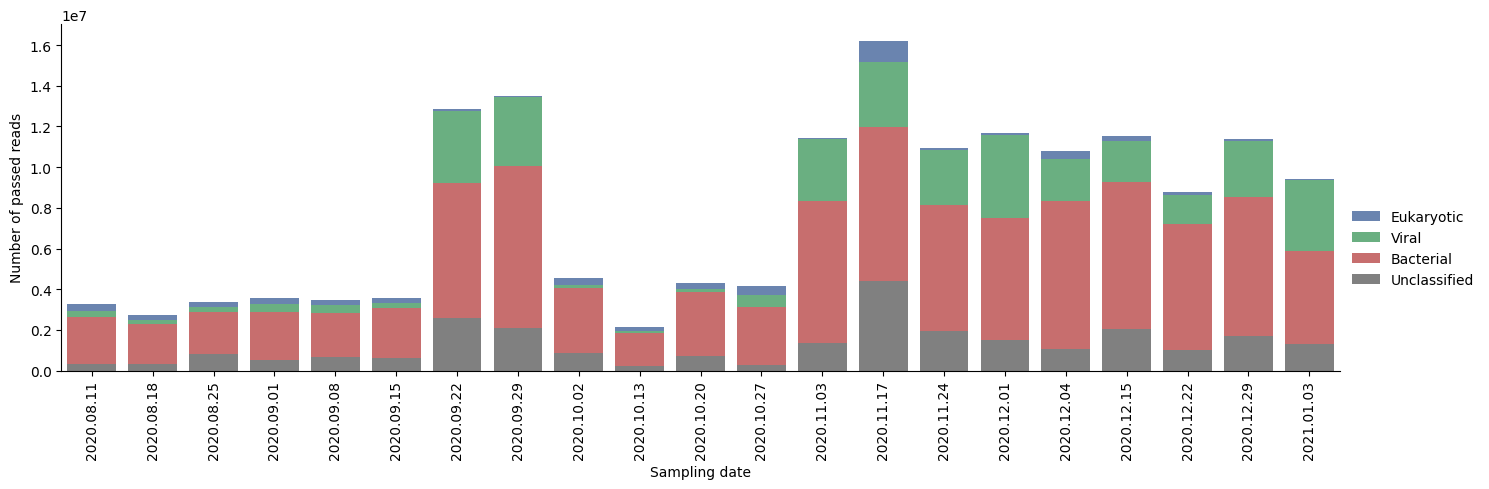

In [26]:
def format_label(label):
    return label.split('_')[0].capitalize()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=summary_df, x=summary_df.sampling_date, y=unclass, label=format_label(unclass), color='#808080')
sns.barplot(data=summary_df, x=summary_df.sampling_date, y=bac, label=format_label(bac), color='#d65f5f', bottom=summary_df[unclass])
sns.barplot(data=summary_df, x=summary_df.sampling_date, y=vir, label=format_label(vir), color='#5fba7d', bottom=summary_df[unclass] + summary_df[bac])
sns.barplot(data=summary_df, x=summary_df.sampling_date, y=euk, label=format_label(euk), color='#5f81ba', bottom=summary_df[unclass] + summary_df[bac] + summary_df[vir])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', ncol=1, frameon=False, bbox_to_anchor=(1, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel('Number of passed reads')
if display_as_percent:
    plt.ylabel('Percentage of passed reads')
plt.tight_layout()
# plt.show()
plt.savefig('kraken_barplot.png', dpi=300)

### What is the % of viral reads in each sample?

In [178]:
unclassified_contigs = {}
viral_contigs = {}
contig_vir_lookup_df = df.to_dict()['virus_score']

for sample in samples:

    bam = f'{bam_dir}/{assembler}-{group}-{sample}.bam'
    fastq1=f'{kraken_dir}/{sample}/{sample}_uncassified_1.fq.gz'
    fastq2=f'{kraken_dir}/{sample}/{sample}_uncassified_2.fq.gz'

    # Get unmapped read IDs from the FASTQ file
    unclass_read_ids = set()
    with pysam.FastxFile(fastq1) as fastq:
        for read in fastq:
            unclass_read_ids.add(read.name)
    with pysam.FastxFile(fastq2) as fastq:
        for read in fastq:
            unclass_read_ids.add(read.name)
    
    # Get the contig IDs for the reads that were not classified
    read_contigs_ids = {}
    with pysam.AlignmentFile(bam) as bamfile:
        for read in bamfile:
            # Skip unmapped reads
            if read.reference_id == -1:
                continue
            else:
                # Only keep unclassified reads
                if read.query_name in unclass_read_ids:
                    contig = bamfile.get_reference_name(read.reference_id).split("_")[1]
                    # Add new reads
                    if read.query_name not in read_contigs_ids:
                        read_contigs_ids[read.query_name] = [contig]
                    else:
                        # Add new contigs
                        if contig not in read_contigs_ids[read.query_name]:
                            read_contigs_ids[read.query_name].append(contig)

    # print(f'For {sample}, % of unclassified reads that map to contigs: {len(read_contigs_ids)/len(unclass_read_ids) * 100:.2f}% ({len(read_contigs_ids):,}/{len(unclass_read_ids):,})')

    # For each contig ID in the unclassified contigs, get the virus score from the dataframe by matching on the index
    unclassified_contigs[sample] = list(read_contigs_ids.values())
    vir_scores = [statistics.mean([contig_vir_lookup_df[int(contig)] for contig in contigs]) for contigs in unclassified_contigs[sample]]

    # Get contigs with a virus score > 0.8
    virus_score_threshold = 0.8
    viral_contigs[sample] = [contigs for contigs, score in zip(unclassified_contigs[sample], vir_scores) if score > virus_score_threshold]

    # print(f'For {sample}, % of unclassified contigs that are viral: {len(viral_contigs[sample])/len(unclassified_contigs[sample]) * 100:.2f}% ({len(viral_contigs[sample]):,}/{len(unclassified_contigs[sample]):,})')

[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530762.bam.bai


For SRR14530762, % of unclassified reads that map to contigs: 41.46% (264,141/637,140)
For SRR14530762, % of unclassified contigs that are viral: 41.65% (110,024/264,141)
For SRR14530763, % of unclassified reads that map to contigs: 56.23% (387,108/688,478)
For SRR14530763, % of unclassified contigs that are viral: 15.04% (58,218/387,108)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530764.bam.bai


For SRR14530764, % of unclassified reads that map to contigs: 59.55% (303,794/510,167)
For SRR14530764, % of unclassified contigs that are viral: 12.12% (36,831/303,794)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530765.bam.bai


For SRR14530765, % of unclassified reads that map to contigs: 67.39% (547,387/812,266)
For SRR14530765, % of unclassified contigs that are viral: 7.21% (39,472/547,387)
For SRR14530766, % of unclassified reads that map to contigs: 56.74% (175,643/309,542)
For SRR14530766, % of unclassified contigs that are viral: 13.74% (24,126/175,643)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530767.bam.bai


For SRR14530767, % of unclassified reads that map to contigs: 61.79% (198,880/321,879)
For SRR14530767, % of unclassified contigs that are viral: 15.57% (30,963/198,880)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530769.bam.bai


For SRR14530769, % of unclassified reads that map to contigs: 30.35% (85,236/280,801)
For SRR14530769, % of unclassified contigs that are viral: 40.98% (34,933/85,236)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530770.bam.bai


For SRR14530770, % of unclassified reads that map to contigs: 61.21% (425,627/695,405)
For SRR14530770, % of unclassified contigs that are viral: 5.72% (24,364/425,627)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530771.bam.bai


For SRR14530771, % of unclassified reads that map to contigs: 57.99% (132,633/228,714)
For SRR14530771, % of unclassified contigs that are viral: 12.78% (16,957/132,633)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530772.bam.bai


For SRR14530772, % of unclassified reads that map to contigs: 64.47% (545,075/845,458)
For SRR14530772, % of unclassified contigs that are viral: 5.58% (30,438/545,075)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530880.bam.bai


For SRR14530880, % of unclassified reads that map to contigs: 66.34% (1,373,429/2,070,302)
For SRR14530880, % of unclassified contigs that are viral: 41.00% (563,118/1,373,429)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530881.bam.bai


For SRR14530881, % of unclassified reads that map to contigs: 69.64% (1,794,172/2,576,510)
For SRR14530881, % of unclassified contigs that are viral: 37.44% (671,761/1,794,172)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530882.bam.bai


For SRR14530882, % of unclassified reads that map to contigs: 59.70% (1,018,087/1,705,282)
For SRR14530882, % of unclassified contigs that are viral: 39.95% (406,737/1,018,087)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530884.bam.bai


For SRR14530884, % of unclassified reads that map to contigs: 54.85% (558,942/1,019,019)
For SRR14530884, % of unclassified contigs that are viral: 32.62% (182,326/558,942)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530885.bam.bai


For SRR14530885, % of unclassified reads that map to contigs: 62.34% (1,283,834/2,059,539)
For SRR14530885, % of unclassified contigs that are viral: 17.80% (228,582/1,283,834)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530886.bam.bai


For SRR14530886, % of unclassified reads that map to contigs: 54.80% (586,055/1,069,395)
For SRR14530886, % of unclassified contigs that are viral: 31.25% (183,129/586,055)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530887.bam.bai


For SRR14530887, % of unclassified reads that map to contigs: 60.00% (915,304/1,525,415)
For SRR14530887, % of unclassified contigs that are viral: 38.46% (352,066/915,304)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530888.bam.bai


For SRR14530888, % of unclassified reads that map to contigs: 51.23% (684,892/1,336,934)
For SRR14530888, % of unclassified contigs that are viral: 44.82% (306,949/684,892)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530889.bam.bai


For SRR14530889, % of unclassified reads that map to contigs: 64.91% (1,254,764/1,933,189)
For SRR14530889, % of unclassified contigs that are viral: 35.50% (445,419/1,254,764)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530890.bam.bai


For SRR14530890, % of unclassified reads that map to contigs: 34.34% (1,503,719/4,379,344)
For SRR14530890, % of unclassified contigs that are viral: 27.38% (411,738/1,503,719)


[W::hts_idx_load3] The index file is older than the data file: /home/phil/Documents/GitHub/mag/results_rothman_htp/Assembly/MEGAHIT/QC/group-HTP/MEGAHIT-group-HTP-SRR14530891.bam.bai


For SRR14530891, % of unclassified reads that map to contigs: 55.18% (721,962/1,308,458)
For SRR14530891, % of unclassified contigs that are viral: 37.59% (271,352/721,962)


### What is the distribution of contig lengths?

The contig IDs are ordered by length, we can therefore plot the contig IDs against their length to see the distribution of contig lengths.

For contigs that are at least Xbp long, as their length increases, the number of contigs decreases superexponentially (note: the y-axis is shown as a log scale). 

The majority of contigs are less than 1000bp long and the longest contig is ~430kbp long, almost double the length of the next longest contig.

In [180]:
display_as_percent = True

vir_contigs_df = summary_df[['total_raw_reads', 'total_processed_reads', 'classified_reads', 'unclassified_reads', 'viral_reads']].copy()
vir_contigs_df['unclassified_contigs'] = [len(unclassified_contigs[sample]) for sample in summary_df.index]
vir_contigs_df['classified_reads'] = vir_contigs_df['classified_reads'] + vir_contigs_df['unclassified_contigs']
vir_contigs_df['unclassified_reads'] = vir_contigs_df['unclassified_reads'] - vir_contigs_df['unclassified_contigs']
vir_contigs_df['viral_contigs'] = [len(viral_contigs[sample]) for sample in summary_df.index]
vir_contigs_df['viral_reads'] = vir_contigs_df['viral_reads'] + vir_contigs_df['viral_contigs']
vir_contigs_df.loc['total'] = vir_contigs_df.sum()

if display_as_percent:
    vir_contigs_df['viral_contigs (%)'] = vir_contigs_df.viral_contigs / vir_contigs_df.unclassified_contigs * 100
    vir_contigs_df['unclassified_contigs (%)'] = vir_contigs_df.unclassified_contigs / (vir_contigs_df.unclassified_reads + vir_contigs_df.unclassified_contigs) * 100
    vir_contigs_df['unclassified_reads (%)'] = vir_contigs_df.unclassified_reads / vir_contigs_df.total_processed_reads * 100
    vir_contigs_df['viral_reads (%)'] = vir_contigs_df.viral_reads / vir_contigs_df.classified_reads * 100
    vir_contigs_df['classified_reads (%)'] = vir_contigs_df.classified_reads / vir_contigs_df.total_processed_reads * 100

# Reorder columns and rows
cols = ['total_raw_reads', 'total_processed_reads', 'classified_reads', 'unclassified_reads', 'viral_reads', 'unclassified_contigs', 'viral_contigs', 'classified_reads (%)', 'unclassified_reads (%)', 'viral_reads (%)', 'unclassified_contigs (%)', 'viral_contigs (%)']
vir_contigs_df = vir_contigs_df[cols]
vir_contigs_df = vir_contigs_df.sort_index()

# cols = vir_contigs_df.columns
vir_contigs_df.style\
    .bar(subset=cols[:7], color='#d65f5f')\
    .bar(subset=cols[7:], color='#5fba7d', vmax=vmax)\
    .format('{:,.0f}', subset=cols[:7])\
    .format('{:.1f}', subset=cols[7:])

In [27]:
# Filter to keep contigs that are at least X bp long
contig_df = df[df['length'] >= 250].copy()
contig_df['index'] = contig_df.index

# Generate an interactive plot of the contig length distribution
# Plot the contig ID (x-axis) against the contig length (y-axis)
# Use a log scale for the y-axis so that the contigs are more easily visible

px.defaults.template = 'plotly_white'
fig = px.scatter(contig_df, x='index', y='length', log_y=True, hover_data={'length': ':,.0f', 'index': ':,.0f'}, width=1000, height=600)
fig.update_xaxes(title_text='Contig ID')
fig.update_yaxes(title_text='Contig length (bp)')
fig.show()

### What is the distribution of total base pairs for each of the contigs?

For each contig, we have the average coverage ($\overline{cov}$) which is equal to:

$ \overline{cov} = \frac{read\_len \times n\_reads}{contig\_len} = \frac{n\_base\_pairs}{contig\_len} $

Where:
- $read\_len$ = the average length of the reads
- $n\_reads$ = the number of reads (sequence fragments) that exactly align to the contig
- $contig\_len$ = the length of the contig
- $n\_base\_pairs$ = the number of base pairs from reads that exactly align to the contig

<br >

We will be estimating the number of base pairs from the reads which map to the contig (which can be thought of as the contig weight) using the following equation:

$ n\_base\_pairs = \overline{cov} \times contig\_len$

<br >

We will the plot the length of the contigs against the number of base pairs from the reads that map to the contig. In doing so we can see that there is a positive correlation between the length of the contig and the number of base pairs from the reads that map to the contig. This is expected because the longer the contig, the more reads will map to it. However, we can also see that there is a wide range of number of base pairs for any given contig length. This is because the coverage varies across the contigs.

The contigs are also coloured by the bin/MAG they belong to. We can see that:
1. All of the longest contigs belong to the same bin/MAG (002). All of the almost 1000 contigs were classified to be proteobacteria from the _Azonexus_ genus by GTDB-Tk.
2. The contigs with the greatest coverage/total number of base pairs belong to the bin/MAG (001). Most of the contigs were predicted to be viral by geNomad. Most sequences were predicted to be from the _Caudovirales_ order, i.e. bacteriophages, however, the contigs with the highest coverage were predicted to be from the _Martellivirales_ order which mainly consists of plant viruses including the tomato brown rugose fruit virus ([ToBRFV](https://en.wikipedia.org/wiki/Tomato_brown_rugose_fruit_virus))

In [28]:
if 'coverage' in df.columns:
    contig_df['n_base_pairs'] = contig_df['length'] * contig_df['coverage']

    # Use a log colour scale for the contig length
    # fig = px.scatter(contig_df, x='index', y='n_base_pairs', log_x=False, log_y=True, hover_data={'index': ':,.0f', 'length': ':,.0f',  'coverage': ':,.0f', 'n_base_pairs': ':,.0f'}, width=1000, height=600, color='length')
    fig = px.scatter(contig_df, x='length', y='n_base_pairs', log_x=True, log_y=True, hover_data={'index': ':,.0f', 'length': ':,.0f',  'coverage': ':,.0f', 'n_base_pairs': ':,.0f'}, width=1000, height=600, color='bin_id')
    fig.update_xaxes(title_text='Length')
    fig.update_yaxes(title_text='Total number of base pairs that align to the contig (bp)')
    fig.show()

### For each contig, how many reads are from each sample?

Visualising all of the contigs > Xbp by number of reads from each sample

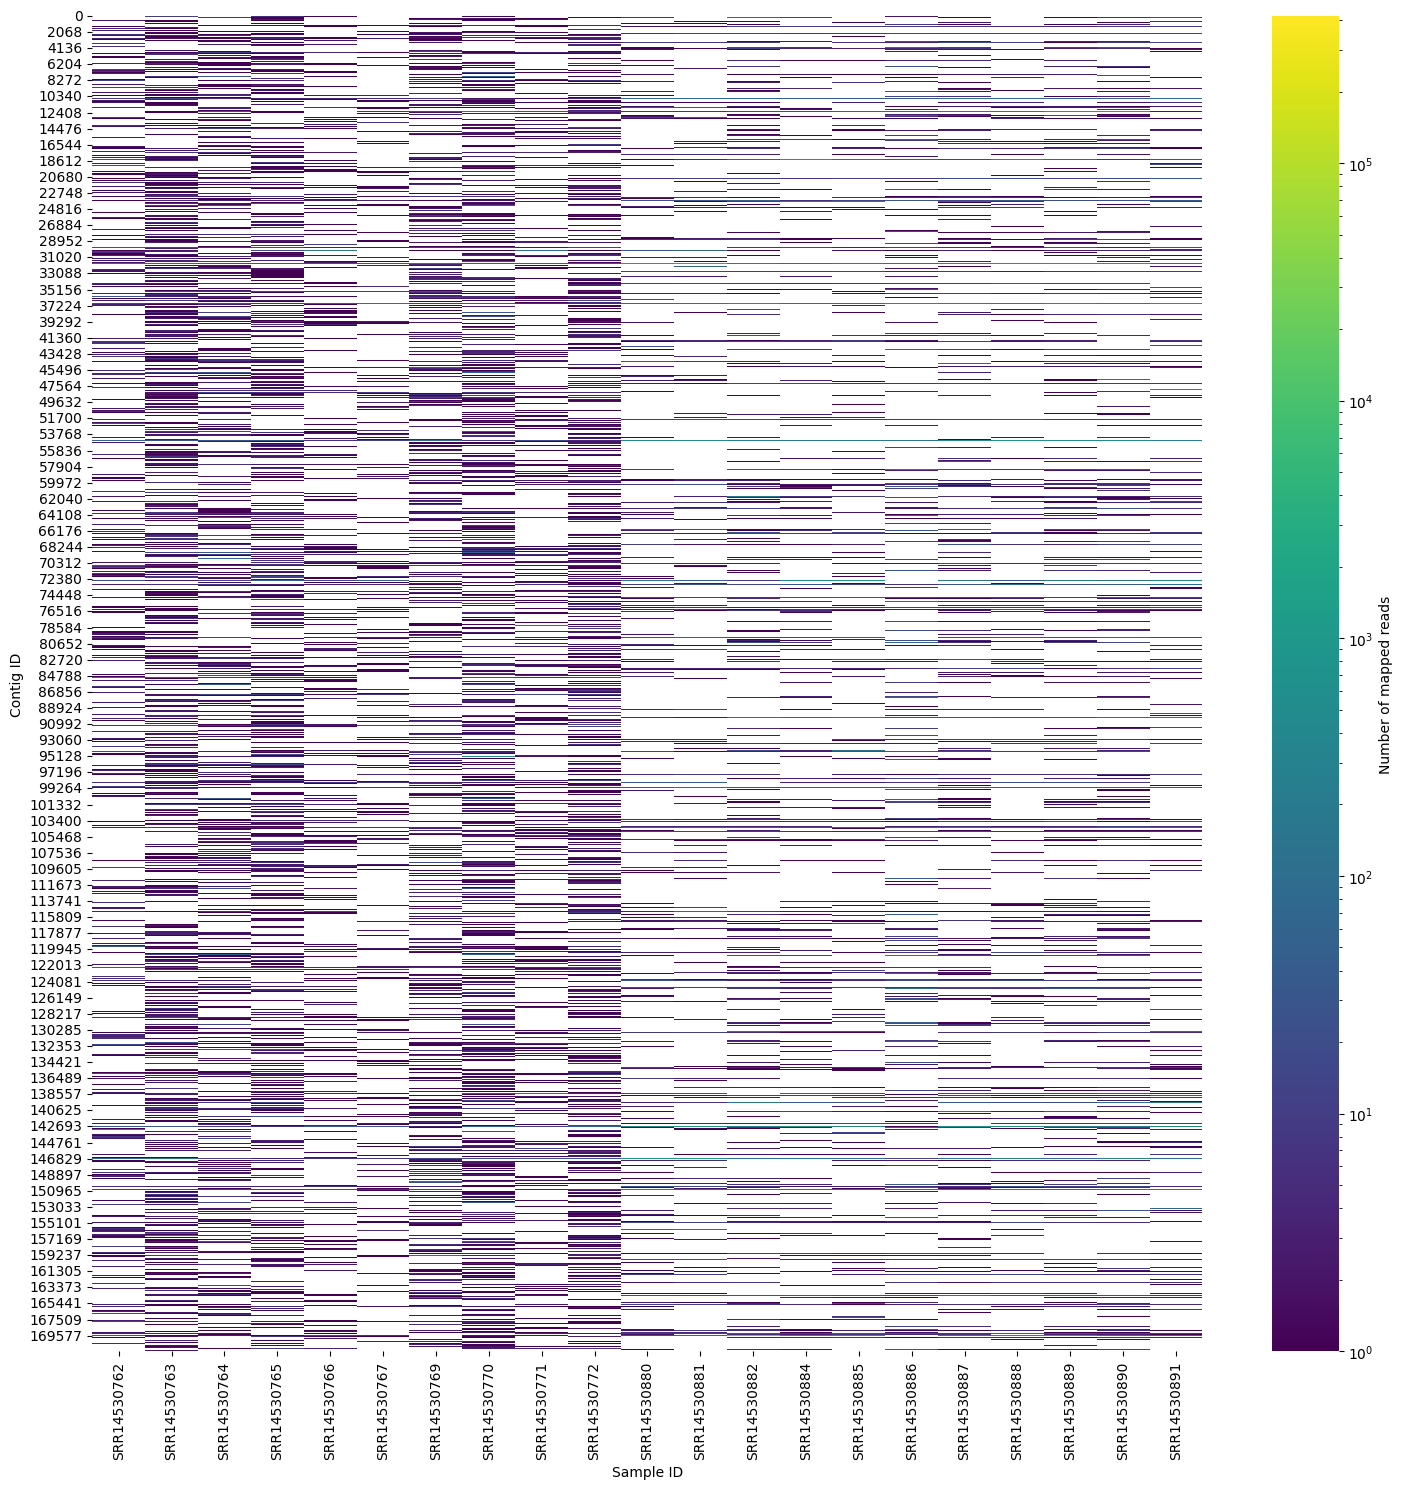

In [334]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(counts_df, cmap='viridis', cbar_kws={'label': 'Number of mapped reads'}, xticklabels=True, norm=LogNorm())
ax.set_xlabel('Sample ID')
ax.set_ylabel('Contig ID')
plt.tight_layout()
plt.show()
# plt.savefig('contig_heatmap.png', dpi=300)

Visualising the top 500 contigs by number of reads from each sample

In [30]:
top_contigs_df = counts_df.head(500).copy()
top_contigs_df['bin_id'] = top_contigs_df.index.map(df['bin_id'])
top_contigs_df['index'] = top_contigs_df.index
# Sort by the bin ID and then by the contig ID
top_contigs_df = top_contigs_df.sort_values(['bin_id', 'index'])

In [31]:
top_contigs_df = counts_df.head(300).copy()

top_contigs_df['bin_id'] = top_contigs_df.index.map(df['bin_id'])
top_contigs_df['index'] = top_contigs_df.index
# Sort by the bin ID and then by the contig ID
top_contigs_df = top_contigs_df.sort_values(['bin_id', 'index'])
del top_contigs_df['bin_id']
del top_contigs_df['index']

x = top_contigs_df.index.tolist()
y = top_contigs_df.values.tolist()
y = list(map(list, zip(*y)))
colors = top_contigs_df.columns.tolist()
# hover_data = []
# for i in range(len(x)):
#     hover_data.append(f'Contig ID: {x[i]}<br>Bin: {df.loc[x[i], "bin_id"]}<br>Classification: {df.loc[x[i], "classification"]}<br>Viral classification: {df.loc[x[i], "lineage"]}')


fig = go.Figure(data=[
    go.Bar(name=colors[i], x=x, y=y[i]) for i in range(len(colors))
])
# Change the bar mode
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, yaxis={'type': 'log'}, width=1000, height=800)
# fig.update_traces(hovertemplate=hover_data)
fig.update_xaxes(title_text='Contig ID')
fig.update_yaxes(title_text='Number of mapped reads')

fig.show()

### What percentage of the reads were used in the assembly?
Using the total number of processed reads for each sample and the counts matrix, we can calculate the percentage of reads used in the assembly for each sample.

The results are promising, because for most of the samples there is a high % use of reads in the assembly. However, as noted in the [samtools documentation](http://www.htslib.org/doc/samtools-idxstats.html) the method we used to calculate the number of reads "may count reads multiple times if they are mapped more than once or in multiple fragments." (Note: this is also why the % use of reads in the assembly is over 100% for some samples). This means the results are likely an overestimate and we cannot be sure if it's the same reads that are found in multiple contigs or if they're unique reads that are found in multiple contigs.

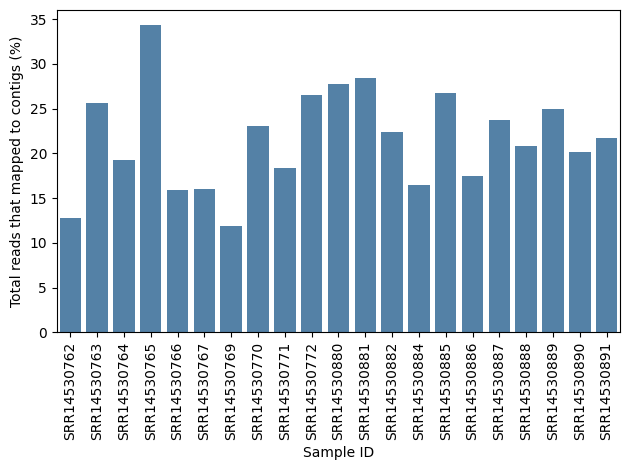

In [32]:
# Get the total number of processed reads for each sample
sample_processed_read_counts = summary_df['total_processed_reads'].to_dict()

# Convert the number of reads mapped to each contig to a percentage of the total number of processed read for each sample
counts_perc_df = counts_df.copy()
for sample in counts_perc_df.columns:
    counts_perc_df[sample] = counts_perc_df[sample] / sample_processed_read_counts[sample] * 100

# Sum the percentage of reads mapped to each contig for each sample
counts_perc_df = pd.DataFrame(counts_perc_df.sum(axis=0), columns=['% reads mapped to contigs'])

# Plot a bar chart of the percentage of reads mapped to each contig for each sample using seaborn
ax = sns.barplot(x=counts_perc_df.index, y='% reads mapped to contigs', data=counts_perc_df, color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Sample ID')
ax.set_ylabel('Total reads that mapped to contigs (%)')
plt.tight_layout()